In [11]:
%load_ext autoreload
%autoreload 2

import os
from travel.constants import MODEL_CACHE_DIR
os.environ['HF_HOME'] = MODEL_CACHE_DIR

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
!nvidia-smi

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Wed Feb 28 10:00:31 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.23.06              Driver Version: 545.23.06    CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A40                     On  | 00000000:CD:00.0 Off |                    0 |
|  0%   30C    P0              71W / 300W |   8862MiB / 46068MiB |      0%   E. Process |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [27]:
from travel.data.captaincook4d import CaptainCook4DDataset

PARTITION = "val"

# Load mistake detection dataset
dataset = CaptainCook4DDataset(data_split=PARTITION,
                               debug_n_examples_per_class=20)

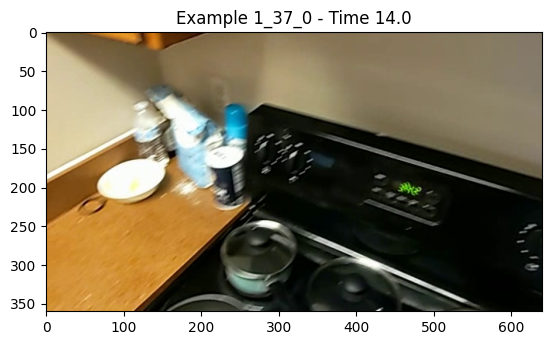

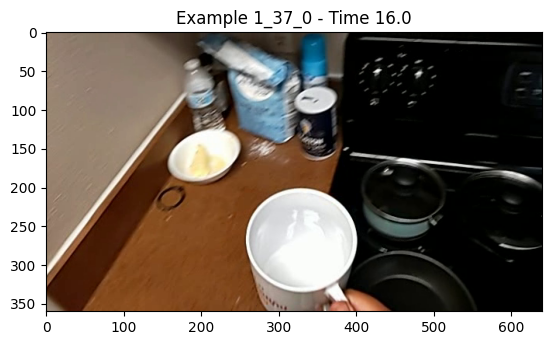

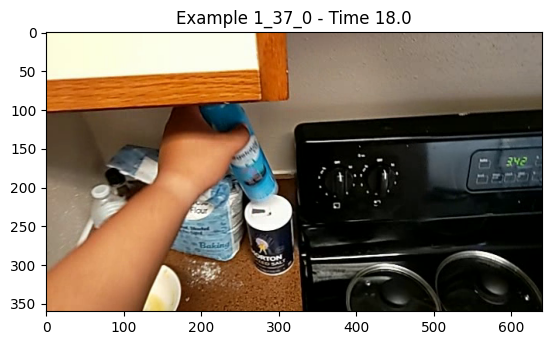

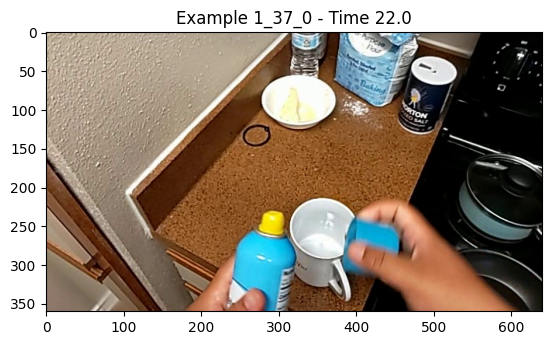

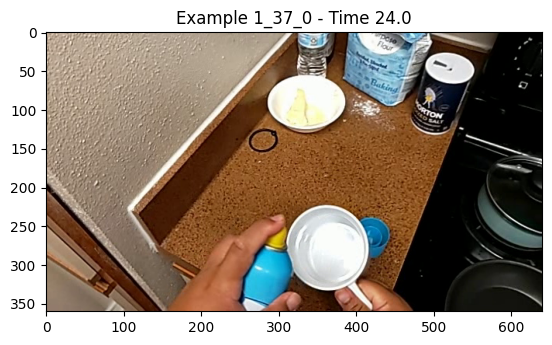

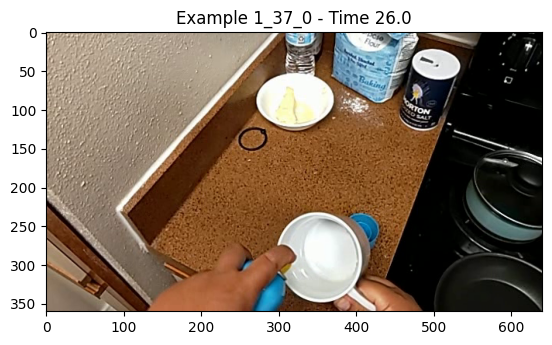

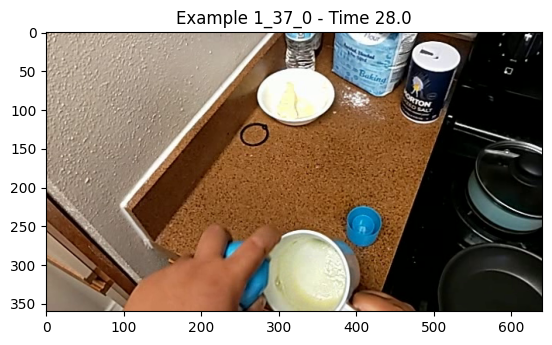

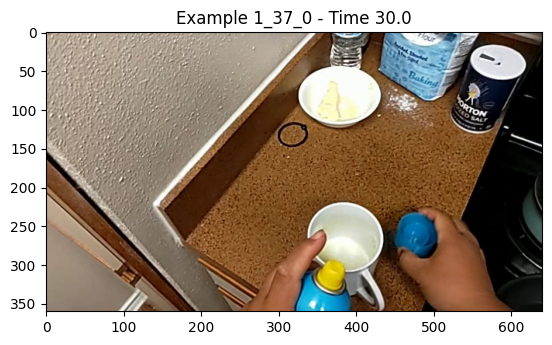

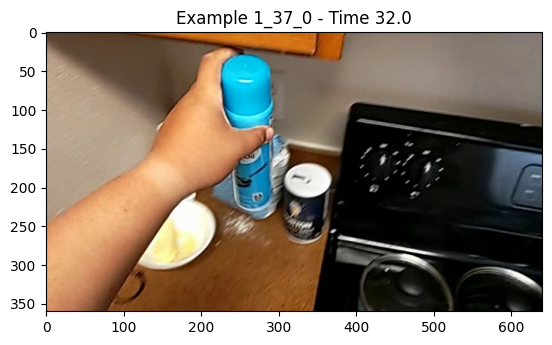

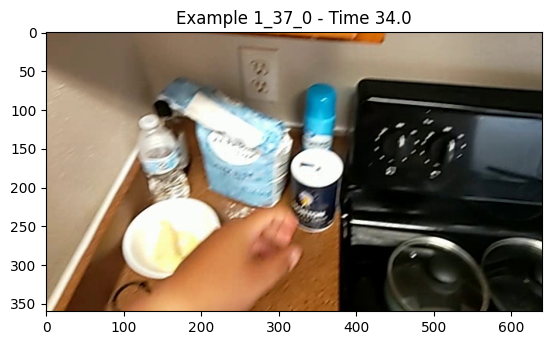

In [14]:
import matplotlib.pyplot as plt

RETRIEVE_ID = "1_37_0"
RETRIEVE_TIMES = [
                14.0,
                16.0,
                18.0,
                22.0,
                24.0,
                26.0,
                28.0,
                30.0,
                32.0,
                34.0
            ]

# RETRIEVE_ID = "10_46_1"
# RETRIEVE_TIMES = [
#                 0.0,
#                 2.0,
#                 4.0,
#                 6.0,
#                 10.0,
#                 14.0,
#                 16.0,
#                 18.0,
#                 20.0,
#                 22.0,
#                 24.0,
#                 24.516
#             ]

# RETRIEVE_ID = "1_37_2"
# RETRIEVE_TIMES = [
#                 0.0,
#                 6.0,
#                 80.0
#             ]

try:
    retrieve_example = [example for example in dataset if example.example_id == RETRIEVE_ID][0]
except:
    print(f"Could not find CaptainCook4D example {RETRIEVE_ID}.")
    raise

for time in RETRIEVE_TIMES:
    found_frame = False
    for frame, frame_time in zip(retrieve_example.frames, retrieve_example.frame_times):
        if round(frame_time, 1) == round(time, 1):
            found_frame = True
            plt.imshow(frame)
            plt.title(f"Example {retrieve_example.example_id} - Time {round(time,1)}")
            plt.show()
    if not found_frame:
        print(f"Could not find frame at time {time} in example {retrieve_example.example_id}.")

In [28]:
from travel.constants import MODEL_CACHE_DIR
import os
os.environ['HF_HOME'] = MODEL_CACHE_DIR

from travel.model.vqg import load_vqg_outputs

from transformers import AutoProcessor, AutoModelForVision2Seq, Owlv2Processor, Owlv2ForObjectDetection

vqg_outputs = load_vqg_outputs("/home/sstorks/coe-chaijy/sstorks/simulation_informed_pcr4nlu/TRAVEl/saved_results/vqg/VQG_Llama-2-7b-hf_icl5_20240227131939")

# Load OWL object detector for filtering frames, and filter frames
detector_processor = Owlv2Processor.from_pretrained("google/owlv2-base-patch16")
detector = Owlv2ForObjectDetection.from_pretrained("google/owlv2-base-patch16", load_in_8bit=True)



The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.
`low_cpu_mem_usage` was None, now set to True since model is quantized.


In [29]:
from travel.model.grounding import filter_frames_by_target_objects

dataset = filter_frames_by_target_objects(dataset, detector, detector_processor, vqg_outputs)

filtering frames: 100%|██████████| 40/40 [00:00<00:00, 18676.63it/s]

Filtered out 576 video frames (904 -> 328).
